# Tuto xgcm

---
### Context
- xgcm is a python packge, motivated by the rapid growth in the numerical resolution of ocean, atmosphere, and climate models.
- xgcm is meant to be a community driven package.
- xgcm is part of the Pangeo initiative.

Documentation : https://xgcm.readthedocs.io

Github : https://github.com/xgcm/xgcm


### Concepts
xgcm consumes and produces xarray data structures, providing convenient indexing and grouping, coordinate-aware data transformations, and (via dask) parallel, out-of-core array computation. 

xgcm is a python packge for working with gridded datasets that are amenable to finite volume analysis. In these datasets,  the different variables are located at different positions according to the Arakawa Grids commonly used in ours models

<img src="images/cgrid.png" width="400" >

xgcm solves the problem of how to interpolate and difference these variables from one position to another.

A fundamental concept in xgcm is the notion of an “axis”, which is a group of dimensions that all lie along the same physical dimension but describe different positions relative to a grid cell. There are currently five possible positions supported by xgcm.

<img src="images/axis.png" width="400">

- center: The variable values are located at the cell center.
- left: The variable values are located at the left (i.e. lower) face of the cell.
- right: The variable values are located at the right (i.e. upper) face of the cell.
- inner: The variable values are located on the cell faces, excludinis a python packgeg both outer boundaries.
- outer: The variable values are located on the cell faces, including both outer boundaries.


### Creating Grid Objects

The core object in xgcm is an xgcm.Grid. 
A Grid object should be constructed once and then used whenever grid-aware operations are required. 
Xgcm operates on xarray.Dataset and xarray.DataArray objects.

When constructing an xgcm.Grid object, we need to pass an xarray.Dataset object containing all of the necessary dimensions and coordinates. We also have to tell xgcm how those dimensions are related to each other (which positions along the axis).


---
**First, import xgcm Grid class**

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xgcm import Grid

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:59664 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 34.36 GB


---

## definitions

In [3]:
def dll_dist(dlon, dlat, lon, lat):
    """
    Converts lat/lon differentials into distances in meters
    
    parameters:
        dlon : xarray.DataArray longitude differentials 
        dlat : xarray.DataArray latitude differentials 
        lon : xarray.DataArray longitude values
        lat : xarray.DataArray latitude values
    returns:
        dx : xarray.DataArray distance inferred from dlon 
        dy : xarray.DataArray distance inferred from dlat 
    """
    
    distance_1deg_equator = 111000.0
    dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator 
    dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
    return dx, dy

def _compute_metrics_curvilinear(ds):
        """
        Create a xgcm grid and set it in the dataset as a attribute
        
        Parameters:
            ds : xarray dataset
        returns:
            ds : xarray dataset with the xgcm  grid
            grid : xgcm grid
        """
        
        # curvilinear grid
        # Create xgcm grid without any metrics
        coords={'x': {'center':'x_rho', 'inner':'x_u'}, 
                'y': {'center':'y_rho', 'inner':'y_v'}, 
                'z': {'center':'s_rho', 'outer':'s_w'}}
        grid = Grid(ds, 
                  coords=coords,
                  boundary='extend')
        
        # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
        ds['nav_lon_u'] = grid.interp(ds.nav_lon_rho,'x')
        ds['nav_lat_u'] = grid.interp(ds.nav_lat_rho,'x')
        ds['nav_lon_v'] = grid.interp(ds.nav_lon_rho,'y')
        ds['nav_lat_v'] = grid.interp(ds.nav_lat_rho,'y')
        ds['nav_lon_psi'] = grid.interp(ds.nav_lon_v,'x')
        ds['nav_lat_psi'] = grid.interp(ds.nav_lat_u,'y')
        _coords = ['nav_lon_u','nav_lat_u','nav_lon_v','nav_lat_v','nav_lon_psi','nav_lat_psi']
        ds = ds.set_coords(_coords)
        
        # add distance metrics for rho, u, v and psi point
        if 'pm' in ds and 'pn' in ds:
            ds['dx_rho'] = 1/ds['pm']
            ds['dy_rho'] = 1/ds['pn']
        else: # backward compatibility, hack
            dlon = grid.interp(grid.diff(ds.nav_lon_rho,'x'),'x')
            dlat =  grid.interp(grid.diff(ds.nav_lat_rho,'y'),'y')
            ds['dx_rho'], ds['dy_rho'] = dll_dist(dlon, dlat, ds.nav_lon_rho, ds.nav_lat_rho)
        dlon = grid.interp(grid.diff(ds.nav_lon_u,'x'),'x')
        dlat = grid.interp(grid.diff(ds.nav_lat_u,'y'),'y')
        ds['dx_u'], ds['dy_u'] = dll_dist(dlon, dlat, ds.nav_lon_u, ds.nav_lat_u)
        dlon = grid.interp(grid.diff(ds.nav_lon_v,'x'),'x')
        dlat = grid.interp(grid.diff(ds.nav_lat_v,'y'),'y')
        ds['dx_v'], ds['dy_v'] = dll_dist(dlon, dlat, ds.nav_lon_v, ds.nav_lat_v)
        dlon = grid.interp(grid.diff(ds.nav_lon_psi,'x'),'x')
        dlat = grid.interp(grid.diff(ds.nav_lat_psi,'y'),'y')
        ds['dx_psi'], ds['dy_psi'] = dll_dist(dlon, dlat, ds.nav_lon_psi, ds.nav_lat_psi)
        ds['dz_w'] = grid.diff(ds.z_w,'z')
        ds['dz_rho'] = grid.diff(ds.z_r,'z')

        # add areas metrics for rho,u,v and psi points
        ds['rArho'] = ds.dx_psi * ds.dy_psi
        ds['rAu'] = ds.dx_v * ds.dy_v
        ds['rAv'] = ds.dx_u * ds.dy_u
        ds['rApsi'] = ds.dx_rho * ds.dy_rho

        metrics = {
               ('x',): ['dx_rho', 'dx_u', 'dx_v', 'dx_psi'], # X distances
               ('y',): ['dy_rho', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
               ('z',): ['dz_rho', 'dz_w'], # Z distances
               ('x', 'y'): ['rArho', 'rAu', 'rAv', 'rApsi'] # Areas
              }
        
        ds.attrs['xgcm-Grid'] = Grid(ds, 
                  coords=coords,
                  metrics = metrics,
                  periodic=False,
                  boundary='extend')
        
        return ds

In [ ]:
def get_z(zeta, h, vtransform, hc, sigma=None, cs=None, theta_s=None, theta_b=None):
    """ 
    Computes z depths 
    
    Parameters
        zeta: xr.DataArray, sea level
        h: xr.DataArray,  water depth
        vtransform: int,  vertical transform
        hc: float,  thickness parameter
        sc: xr.DataArray,  sigma array (-1,0)
        cs: xr.DataArray,  vertical stretching
    Return
        z: xr.DataArray, depths in meters
    """

    if vtransform == 1:
        z0 = hc*sigma + (h-hc)*cs
        z = z0 + (1+z0/h) * zeta
    elif vtransform == 2:
        z0 = (hc * sigma + h * cs) / (hc + h)
        z = z0 * (zeta + h) + zeta

    return z.fillna(0)

---

## load run

In [4]:
# open grid file
root_path = '/Users/slgentil/tmp/'
dst = xr.open_dataset(root_path+'grid.nc')

# get vertical grid parameters
h = dst.h
hc = dst.hc
sc_r = dst.sc_r
cs_r = dst.Cs_r
sc_w = dst.sc_w
cs_w = dst.Cs_w
theta_s = dst.theta_s
theta_b = dst.theta_b
vtransform = dst.Vtransform
mask_rho = dst.mask_rho

In [5]:
# Open data file
ds = xr.open_dataset(root_path+'his.nc').isel(time_counter=0)

# rename redundant dimensions
_dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
for d in _dims:
    ds = ds.rename({d: d[0]+'_rho'})

In [6]:
# compute z at rho/w points
z_r = get_z(ds.ssh, h, vtransform, hc, sigma=sc_r, cs=cs_r, theta_s=theta_s, theta_b=theta_b)
z_r =  z_r.assign_coords(z_r=z_r)
z_w = get_z(ds.ssh, h, vtransform, hc, sigma=sc_w, cs=cs_w, theta_s=theta_s, theta_b=theta_b)
z_w =  z_w.assign_coords(z_w=z_w)

# assigne z coordinates to dataset
ds['z_r'] = z_r
ds['z_w'] = z_w
ds = ds.set_coords(['z_r','z_w'])

In [7]:
# Add an xgcm Grid instance to the dataset
ds = _compute_metrics_curvilinear(ds)
xgcmgrid = ds.attrs['xgcm-Grid']
ds

<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, s_rho: 180, s_w: 181, x_rho: 1026, x_u: 1025, y_rho: 1026, y_v: 1025)
Coordinates:
    nav_lat_rho          (y_rho, x_rho) float32 -25.6 -25.6 ... -16.181475
    nav_lat_u            (y_rho, x_u) float32 -25.6 -25.6 ... -16.181475
    nav_lat_v            (y_v, x_rho) float32 -25.595558 ... -16.186203
    nav_lon_rho          (y_rho, x_rho) float32 34.5 34.50985 ... 44.59625
    nav_lon_u            (y_rho, x_u) float32 34.504925 34.514774 ... 44.591324
    nav_lon_v            (y_v, x_rho) float32 34.5 34.50985 ... 44.5864 44.59625
  * s_rho                (s_rho) float32 -0.99722224 ... -0.0027777778
    time_counter         datetime64[ns] 1901-07-02
    time_instant         datetime64[ns] ...
    z_r                  (s_rho, y_rho, x_rho) float64 -312.6 -296.9 ... 0.0 0.0
  * s_w                  (s_w) float32 -1.0 -0.99444443 ... -0.0055555557 0.0
    z_w                  (s_w, y_rho, x_rho) float64 -316.9 -301.0 ... 0.0 0.0
    nav_lon_psi          (y_v, x_u) float32 34.504925 34.514774 ... 44.591324
    nav_lat_psi          (y_v, x_u) float32 -25.595558 -25.595558 ... -16.186203
Dimensions without coordinates: axis_nbounds, x_rho, x_u, y_rho, y_v
Data variables:
    rho                  (s_rho, y_rho, x_rho) float32 ...
    salt                 (s_rho, y_rho, x_rho) float32 ...
    ssh                  (y_rho, x_rho) float32 ...
    temp                 (s_rho, y_rho, x_rho) float32 ...
    time                 float32 ...
    time_counter_bounds  (axis_nbounds) datetime64[ns] ...
    time_instant_bounds  (axis_nbounds) datetime64[ns] ...
    u                    (s_rho, y_rho, x_u) float32 ...
    v                    (s_rho, y_v, x_rho) float32 ...
    w                    (s_rho, y_rho, x_rho) float32 ...
    dx_rho               (y_rho, x_rho) float32 985.9733 985.9733 ... 1049.9874
    dy_rho               (y_rho, x_rho) float32 1017.9291 ... 1017.9291
    dx_u                 (y_rho, x_u) float32 -504348.5 985.9733 ... -537093.2
    dy_u                 (y_rho, x_u) float32 1017.9291 1017.9291 ... 1017.9291
    dx_v                 (y_v, x_rho) float32 986.0101 986.0101 ... 1049.9624
    dy_v                 (y_v, x_rho) float32 -521726.22 ... -521694.16
    dx_psi               (y_v, x_u) float32 -504367.25 986.0101 ... -537080.3
    dy_psi               (y_v, x_u) float32 -521726.22 -521726.22 ... -521694.16
    dz_w                 (s_rho, y_rho, x_rho) float64 8.582 8.14 ... 0.0 0.0
    dz_rho               (s_w, y_rho, x_rho) float64 -312.5 -296.8 ... 0.0 0.0
    rArho                (y_v, x_u) float32 263141620000.0 ... 280191660000.0
    rAu                  (y_v, x_rho) float32 -514427300.0 ... -547759200.0
    rAv                  (y_rho, x_u) float32 -513391000.0 ... -546722750.0
    rApsi                (y_rho, x_rho) float32 1003650.94 ... 1068812.8
Attributes:
    name:         his
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Jul-01 10:44:41 GMT
    uuid:         5e14c5d4-daa1-4b15-bd18-5afc78470f1b
    history:      Tue Nov 24 08:51:25 2020: ncks -d time_counter,0,0 his.nc /...
    NCO:          4.7.1
    xgcm-Grid:    <xgcm.Grid>\nx Axis (not periodic, boundary='extend'):\n  *...

---

## Difference to the intermediate grid point.
advantages: as numpy, no matter to know the axe number, change dimensions, keep coordinates

In [8]:
print(ds.z_w.dims)
print(ds.z_w.coords)

('s_w', 'y_rho', 'x_rho')
Coordinates:
    nav_lat_rho   (y_rho, x_rho) float32 -25.6 -25.6 ... -16.181475 -16.181475
    nav_lon_rho   (y_rho, x_rho) float32 34.5 34.50985 ... 44.5864 44.59625
    time_counter  datetime64[ns] 1901-07-02
    time_instant  datetime64[ns] 1901-07-02
  * s_w           (s_w) float32 -1.0 -0.99444443 ... -0.0055555557 0.0
    z_w           (s_w, y_rho, x_rho) float64 -316.9 -301.0 -285.8 ... 0.0 0.0


('s_rho', 'y_rho', 'x_rho')
Coordinates:
  * s_rho        (s_rho) float32 -0.99722224 -0.9916667 ... -0.0027777778
    nav_lat_rho  (y_rho, x_rho) float32 ...
    nav_lon_rho  (y_rho, x_rho) float32 ...


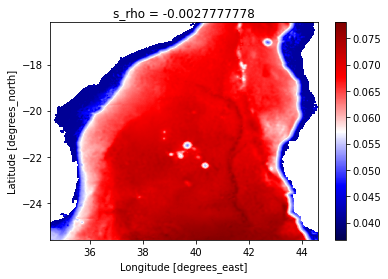

In [26]:
dz = xgcmgrid.diff(ds.z_w,'z')*mask_rho
print(dz.dims)
print(dz.coords)
dz.isel(s_rho=-1).plot(x='nav_lon_rho', y='nav_lat_rho', cmap='seismic')

---

## Interpolation to the intermediate grid point : Kinetic energy
\begin{equation}
\frac{1}{2}(u^2 + v^2)
\end{equation}

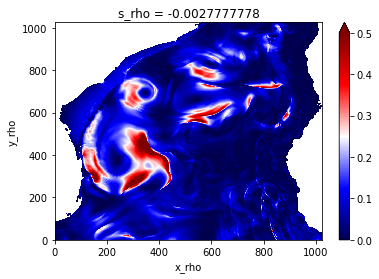

In [16]:
ke = 0.5 * (xgcmgrid.interp(ds.u**2,'x') + xgcmgrid.interp(ds.v**2,'y'))
ke.isel(s_rho=-1).plot(cmap='seismic', vmin=0, vmax=0.5)

---

## Derivatives : relative vorticity
\begin{equation}
\xi = - \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}
\end{equation}

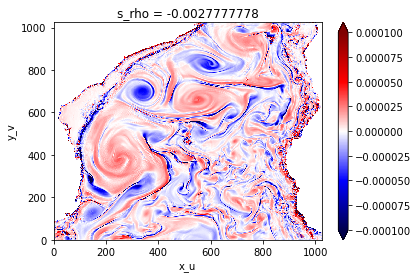

In [17]:
vort = (-xgcmgrid.derivative(ds.u, 'y') + xgcmgrid.derivative(ds.v, 'x'))
vort.isel(s_rho=-1).plot(vmin=-1e-4, vmax=1e-4, cmap='seismic')

---

## Integration :   
\begin{equation}
\int_{-H}^0 \rho.dz
\end{equation}

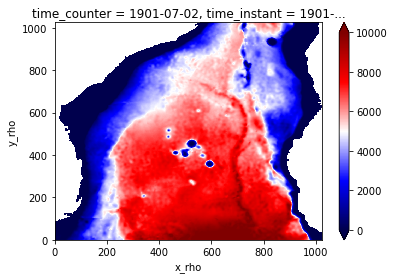

In [18]:
var = xgcmgrid.integrate(ds.rho, 'z')*mask_rho
var.plot(cmap='seismic', vmin=0, vmax=10e3)

---

## Weighted average :   
\begin{equation}
\frac{\int_{-H}^0 S.dz}{\int_{-H}^0 dz}
\end{equation}

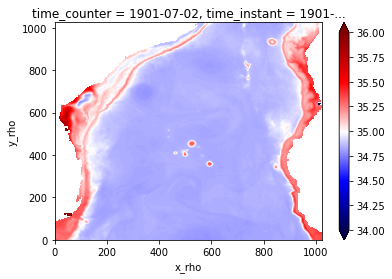

In [19]:
var = xgcmgrid.average(ds.salt, 'z')*mask_rho
var.plot(cmap='seismic', vmin=34, vmax=36)

---

## Transforming coordinates :   


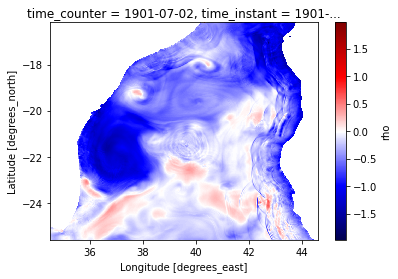

In [21]:
# Interpolate rho at depth=-100m
var = xgcmgrid.transform(ds.rho, 'z', [-100], target_data=ds.z_r).compute()
var.plot(x='nav_lon_rho', y='nav_lat_rho', cmap='seismic')

/Users/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/xgcm/transform.py:60: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return _interp_1d_linear(phi, theta, target_theta_levels, mask_edges)


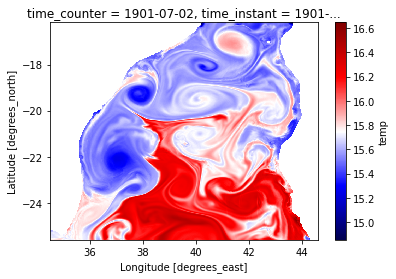

In [25]:
# Interpolate temperature on an isodensity=1
var = xgcmgrid.transform(ds.temp, 'z', [1], target_data=ds.rho).compute()
var.plot(x='nav_lon_rho', y='nav_lat_rho', cmap='seismic')

In [ ]:
cluster.close()